<a href="https://colab.research.google.com/github/Niveditha-Angaraju/NL-simulation/blob/main/NavigatedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygame gym numpy torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Training Progress: 100%|██████████| 2000/2000 [1:40:32<00:00,  3.02s/it]


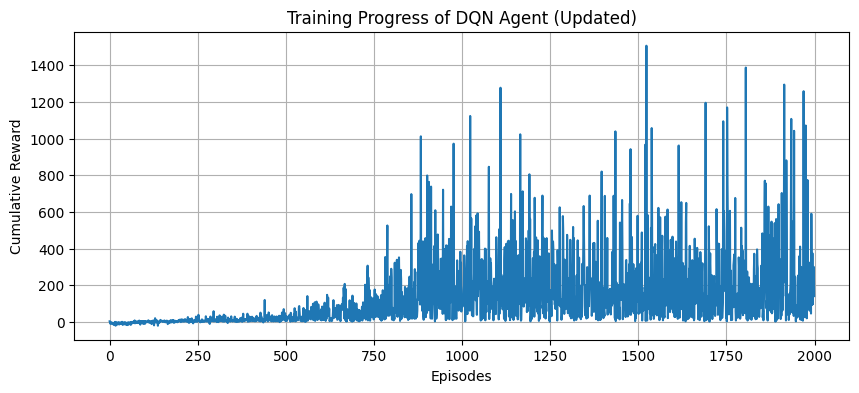

In [ ]:
# --- Load extracted_data.json ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import trange
import gym
from gym import spaces

json_path = "/content/extracted_data.json"
if not os.path.exists(json_path):
    from google.colab import files
    uploaded = files.upload()

with open(json_path, "r") as f:
    extracted_data = json.load(f)

# --- Preprocess resource coordinates and scale to grid ---
SCALE = 100
resource_cells = []
for name, data in extracted_data.items():
    x = int(float(data['x_coordinate']) * SCALE)
    y = int(float(data['y_coordinate']) * SCALE)
    resource_cells.append((x, y))

# Normalize coordinates to start from (0, 0)
min_x = min(x for x, y in resource_cells)
min_y = min(y for x, y in resource_cells)

# Adjust coordinates and determine max
adjusted_resources = [(x - min_x, y - min_y) for x, y in resource_cells]
max_x = max(x for x, y in adjusted_resources)
max_y = max(y for x, y in adjusted_resources)

GRID_SIZE_X = max_x + 1
GRID_SIZE_Y = max_y + 1

# --- Custom GridEnv Class ---
class GridEnv(gym.Env):
    def __init__(self, resources, grid_size_x=GRID_SIZE_X, grid_size_y=GRID_SIZE_Y):
        super(GridEnv, self).__init__()
        self.grid_size_x = grid_size_x
        self.grid_size_y = grid_size_y
        self.start_pos = (0, 0)
        self.goal_pos = (grid_size_x - 1, grid_size_y - 1)
        self.agent_pos = self.start_pos

        self.action_space = spaces.Discrete(2)  # 0: UP, 1: RIGHT
        self.observation_space = spaces.Discrete(grid_size_x * grid_size_y)
        self.resources = set(resources)

    def reset(self):
        self.agent_pos = self.start_pos
        return self._get_state(), {}

    def step(self, action):
        x, y = self.agent_pos
        if action == 0 and y < self.grid_size_y - 1:
            y += 1  # UP
        elif action == 1 and x < self.grid_size_x - 1:
            x += 1  # RIGHT
        self.agent_pos = (x, y)

        reward = 1.0 if self.agent_pos in self.resources else -0.4
        done = self.agent_pos == self.goal_pos
        return self._get_state(), reward, done, {}

    def _get_state(self):
        return self.agent_pos[1] * self.grid_size_x + self.agent_pos[0]

# --- DQN Model ---
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# --- Training Function ---
def train_dqn(env, episodes=500, gamma=0.95, epsilon=1.0, epsilon_decay=0.995,
              min_epsilon=0.01, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    memory = deque(maxlen=2000)
    state_size = env.observation_space.n
    action_size = env.action_space.n
    model = DQN(state_size, action_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    rewards = []

    for episode in trange(episodes, desc="Training Progress"):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.eye(state_size)[state].unsqueeze(0).to(device)
                    q_values = model(state_tensor)
                    action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            memory.append((state, action, reward, next_state, done))
            state = next_state

            if len(memory) >= batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards_, next_states, dones = zip(*batch)

                states_tensor = torch.stack([torch.eye(state_size)[s] for s in states]).to(device)
                next_states_tensor = torch.stack([torch.eye(state_size)[s] for s in next_states]).to(device)
                actions_tensor = torch.LongTensor(actions).to(device)
                rewards_tensor = torch.FloatTensor(rewards_).to(device)
                dones_tensor = torch.FloatTensor(dones).to(device)

                q_values = model(states_tensor).gather(1, actions_tensor.unsqueeze(1)).squeeze()
                next_q = model(next_states_tensor).detach()
                q_targets = rewards_tensor + gamma * torch.max(next_q, dim=1)[0] * (1 - dones_tensor)

                loss = criterion(q_values, q_targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards.append(total_reward)

    return model, rewards

# --- Train the Model ---
env = GridEnv(resources=adjusted_resources)
model, rewards = train_dqn(env, episodes=2000)

# --- Plot the Training Rewards ---
plt.figure(figsize=(10, 4))
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Training Progress of DQN Agent (Updated)")
plt.grid(True)
plt.show()


In [ ]:
# Save the trained model
torch.save(model.state_dict(), "grid_model.pth")

# Download the model file
from google.colab import files
files.download("grid_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>